# Notebook to calculate Statistics

### Import the libraries###

In [ ]:
import json
import sys
import pandas as pd
import collections 
import os
import numpy as np
from itertools import chain
from itertools import combinations
sys.path.append('/home/jkuettel/NLP_spark/src')
sys.path.append('/home/jkuettel/NLP_spark')
from src.experiment_utils.helper_classes import token, span, repository
from src.d02_corpus_statistics.corpus import Corpus
from definitions import ROOT_DIR
from pyannote.core import Segment

## Small Tutorial



### Classes and Dataframe

All the information is now stored in a dataframe called "stat_df" containing the string of the directory path, the raw text, and all the annotations (in form of list of spans) starting with the Curation:

In [ ]:
    
dataframe_dir = os.path.join(ROOT_DIR,'data/02_processed_to_dataframe', 'preprocessed_dataframe.pkl')
stat_df = pd.read_pickle(dataframe_dir)
stat_df.head()

The spans of each paragraph are stored in list:

In [3]:
stat_df['Curation'][2]

[annotator:curation layer:Instrumenttypes type:InstrumentType tag:VoluntaryAgrmt start:12 stop:26 text:joint projects,
 annotator:curation layer:Instrumenttypes type:InstrumentType tag:VoluntaryAgrmt start:164 stop:178 text:joint projects,
 annotator:curation layer:Instrumenttypes type:InstrumentType tag:Unspecified start:1662 stop:1676 text:support scheme,
 annotator:curation layer:Instrumenttypes type:InstrumentType tag:PublicInvt start:1707 stop:1721 text:investment aid,
 annotator:curation layer:Instrumenttypes type:InstrumentType tag:Subsidies_Incentives start:1707 stop:1721 text:investment aid,
 annotator:curation layer:Instrumenttypes type:InstrumentType tag:VoluntaryAgrmt start:1879 stop:1967 text:council of europe convention for the protection of human rights and fundamental freedoms,
 annotator:curation layer:Instrumenttypes type:InstrumentType tag:VoluntaryAgrmt start:1978 stop:2031 text:international conventions or treaties on human rights,
 annotator:curation layer:Instrum

Each span has a layer, type, tag, start, stop, and the annotatet text (raw)

In [4]:
stat_df['Curation'][2][2]

annotator:curation layer:Instrumenttypes type:InstrumentType tag:Unspecified start:1662 stop:1676 text:support scheme

Further has each tag a repository, list of all the tokens and a annotator

In [5]:
stat_df['Curation'][2][2].rep

policy:EU_32018L2001 title:Title_0 chapter:Chapter_0 section:Section_0 article:Article_11

In [6]:
stat_df['Curation'][2][2].tokens

[start:1662 stop:1669 text:support tag_count:3,
 start:1670 stop:1676 text:scheme tag_count:3]

In [7]:
stat_df['Curation'][2][2].annotator

'curation'

It is important to note that the token objects reside in the separate column tokens, the list of tokens for each tag is just a pointer to those objects residing in the token column.

Each Token has a start, stop, text and a tag_count. The tag_count counts how many times this specific tokens has been labeled.

In [8]:
stat_df['Tokens'][2][49]

start:269 stop:276 text:involve tag_count:0

Repository's can be created trought the normal constructor **init**(self, policy, title, chapter, section, article) , or trough the classmethod **from_repository_name**(cls, rep_str), taking only a big string of the repository name. 

### Conditional Repository

The repository class can be used to create conditional repositorys, which are usefull to search in all the paragraphs matching a certain condition. Let's go on and create a test repository:

In [14]:
test_dir = repository.from_repository_name("EU_32008R1099_Title_0_Chapter_0_Section_0_Article_03")
test_dir

policy:EU_32008R1099 title:Title_0 chapter:Chapter_0 section:Section_0 article:Article_03

Let's now create a conditional repository. On each hirarchy, I can either match a certain name or I can match all the names by inserting 'None'. Simply speaking, we match all repositorys with the attributes given other than 'None. Let's assume I want to match all the tags in 'EU_32008R1099' I would create a repository like this:

In [15]:
test_dir = repository(policy = 'EU_32008R1099', title = None, chapter = None, section = None, article = None)
test_dir

policy:EU_32008R1099 title:None chapter:None section:None article:None

or simply

In [16]:
test_dir = repository(policy = 'EU_32008R1099')
test_dir

policy:EU_32008R1099 title:None chapter:None section:None article:None

If I want to match all the tags that are stored in the first article in all the policy's, titles, chapters and sections

In [34]:
test_dir = repository( article = 'Article_01')
test_dir

policy:None title:None chapter:None section:None article:Article_01

### Class Evaluator and evaluation functions

All the funtions calculating statistics are contained the class "Corpus", it's only class member is the dataframe:

In [5]:
test_corpus = Corpus(stat_df)

The most important funtion is the member function get_span_list(self, conditional_rep, columns, item, value). This functions takes a conditional repository (explained before), a item which can be either 'class, 'type' or 'tag' and a value. E.g item = 'layer' and value = 'Policydesigncharacteristics' or item = 'type and value ='Compliance' and item = 'tag' and value = 'Form_monitoring'. 

The function returns a list of all the tags in all the paragraphs matching the conditional repository and matching the item and value given. E.g I want to match all the tags of type 'Policydesigncharacteristics' in the policy 'EU_32008R1099':

In [7]:
test_dir = repository('EU_32008R1099')
test_corpus.get_span_list(conditional_rep = test_dir, columns = 'annotators')


[annotator:Alisha layer:Policydesigncharacteristics type:Time tag:Time_InEffect start:76 stop:110 text:20th day following its publication,
 annotator:Alisha layer:Policydesigncharacteristics type:Actor tag:Addressee_default start:239 stop:252 text:member states,
 annotator:Fride layer:Policydesigncharacteristics type:Time tag:Time_InEffect start:76 stop:134 text:20th day following its publication in the official journal,
 annotator:Fride layer:Policydesigncharacteristics type:Actor tag:Addressee_default start:239 stop:252 text:member states,
 annotator:Onerva layer:Policydesigncharacteristics type:Time tag:Time_InEffect start:52 stop:156 text:enter into force on the 20th day following its publication in the official journal of the european union,
 annotator:Onerva layer:Policydesigncharacteristics type:Actor tag:Addressee_default start:239 stop:252 text:member states,
 annotator:Alisha layer:Policydesigncharacteristics type:Actor tag:Authority_legislative start:47 stop:66 text:european

If I don't want to specify the item and the value, so match all the tags that match the conditional repository, I can put 'None':

In [19]:
test_corpus.get_span_list(conditional_rep = test_dir, item = 'layer', value = 'Policydesigncharacteristics')

[annotator:curation layer:Policydesigncharacteristics type:Time tag:Time_InEffect start:76 stop:134 text:20th day following its publication in the official journal,
 annotator:curation layer:Policydesigncharacteristics type:Time tag:Time_InEffect start:76 stop:110 text:20th day following its publication,
 annotator:curation layer:Policydesigncharacteristics type:Actor tag:Addressee_default start:239 stop:252 text:member states,
 annotator:Alisha layer:Policydesigncharacteristics type:Time tag:Time_InEffect start:76 stop:110 text:20th day following its publication,
 annotator:Alisha layer:Policydesigncharacteristics type:Actor tag:Addressee_default start:239 stop:252 text:member states,
 annotator:Fride layer:Policydesigncharacteristics type:Time tag:Time_InEffect start:76 stop:134 text:20th day following its publication in the official journal,
 annotator:Fride layer:Policydesigncharacteristics type:Actor tag:Addressee_default start:239 stop:252 text:member states,
 annotator:Onerva la

All the other member functions are based on the Corpus.get_tag_list member function, they also take the same inputs. 

get_span_distro(self, conditional_rep, item, value, return_format) returns the distribution of spans of a tag_list either in dict{span:count} or list format. The lenght of the span can be calculated on character or token level:

In [20]:
test_corpus.get_span_distro(conditional_rep = test_dir, return_format = 'dict', level = 'character')

{10: 33,
 19: 19,
 20: 16,
 13: 14,
 17: 14,
 8: 14,
 9: 14,
 6: 12,
 21: 12,
 11: 11,
 18: 8,
 4: 8,
 7: 7,
 15: 7,
 35: 6,
 27: 6,
 12: 6,
 16: 4,
 25: 4,
 5: 4,
 31: 3,
 22: 3,
 29: 2,
 42: 2,
 23: 2,
 14: 2,
 24: 2,
 45: 2,
 36: 2,
 28: 2,
 58: 1,
 34: 1,
 3: 1,
 81: 1,
 99: 1,
 72: 1,
 59: 1,
 86: 1,
 76: 1,
 30: 1,
 108: 1,
 33: 1}

In [21]:
test_corpus.get_span_distro(conditional_rep = test_dir, return_format = 'list')

[0,
 0,
 1,
 8,
 4,
 12,
 7,
 14,
 14,
 33,
 11,
 6,
 14,
 2,
 7,
 4,
 14,
 8,
 19,
 16,
 12,
 3,
 2,
 2,
 4,
 0,
 6,
 2,
 2,
 1,
 3,
 0,
 1,
 1,
 6,
 2,
 0,
 0,
 0,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1]

In [23]:
test_corpus.get_span_distro(conditional_rep = test_dir, return_format = 'dict', level = 'token')

{1: 104,
 2: 87,
 4: 18,
 3: 16,
 5: 7,
 6: 6,
 9: 4,
 7: 3,
 11: 2,
 8: 1,
 13: 1,
 14: 1,
 10: 1,
 12: 1,
 15: 1}

This span ditro can also be plottet:

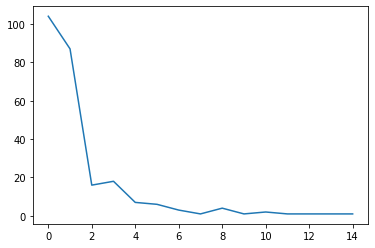

In [25]:
import matplotlib.pyplot as plt
plt.plot(test_corpus.get_span_distro(conditional_rep = test_dir, return_format = 'list', level = 'token'))
plt.show()

get_span_count(self, article, item, value) returns # of tags in the tag_list. Can be used to retrieve the amount of tags matching a certain condition. E.g all the tags of class 'Policydesigncharacteristics' in the policy 'EU_32008R1099':

In [28]:
test_corpus.get_span_count(item = 'layer', value = 'Policydesigncharacteristics', conditional_rep = test_dir)

210

get_tokens_from_span_list(self, conditional_rep, item, value) returns a list of all the tokens in a taglist

In [30]:
test_corpus.get_tokens_from_span_list(item = 'layer', value = 'Policydesigncharacteristics', conditional_rep = test_dir)

[start:76 stop:80 text:20th tag_count:5,
 start:81 stop:84 text:day tag_count:5,
 start:85 stop:94 text:following tag_count:5,
 start:95 stop:98 text:its tag_count:5,
 start:99 stop:110 text:publication tag_count:5,
 start:111 stop:113 text:in tag_count:3,
 start:114 stop:117 text:the tag_count:3,
 start:118 stop:126 text:official tag_count:3,
 start:127 stop:134 text:journal tag_count:3,
 start:76 stop:80 text:20th tag_count:5,
 start:81 stop:84 text:day tag_count:5,
 start:85 stop:94 text:following tag_count:5,
 start:95 stop:98 text:its tag_count:5,
 start:99 stop:110 text:publication tag_count:5,
 start:239 stop:245 text:member tag_count:4,
 start:246 stop:252 text:states tag_count:4,
 start:47 stop:55 text:european tag_count:4,
 start:56 stop:66 text:parliament tag_count:4,
 start:78 stop:85 text:council tag_count:4,
 start:112 stop:118 text:energy tag_count:3,
 start:119 stop:129 text:statistics tag_count:2,
 start:142 stop:145 text:eea tag_count:2,
 start:162 stop:170 text:europ

get_token_count_from_span_list returns the amount of tokens in the tag_list:

In [32]:
test_corpus.get_token_count_from_span_list(item = 'layer', value = 'Policydesigncharacteristics', conditional_rep = test_dir)

536

most_frequent_labeled_tokens(self, conditional_rep, item, value) returns a dict of all the most frequent tokens of a span_list

In [33]:
test_corpus.most_frequent_labeled_tokens(item = 'layer', value = 'Policydesigncharacteristics', conditional_rep = test_dir)

{'statistics': 57,
 'energy': 30,
 'commission': 24,
 'eurostat': 19,
 'the': 16,
 '/': 15,
 'national': 14,
 'of': 13,
 'and': 13,
 'member': 12,
 '(': 12,
 ')': 12,
 'states': 11,
 'community': 11,
 'ec': 9,
 'data': 8,
 'final': 7,
 'consumption': 7,
 'annual': 6,
 'nuclear': 6,
 'renewable': 6,
 'decision': 6,
 'european': 5,
 'following': 4,
 'council': 4,
 'reported': 4,
 'no': 4,
 '\xa0': 4,
 ',': 4,
 'statistical': 4,
 'regulation': 4,
 'monthly': 4,
 'parliament': 3,
 'treaty': 3,
 'studies': 3,
 'for': 3,
 'monitoring': 3,
 'gas': 3,
 'months': 3,
 'year': 3,
 '1999': 3,
 '468': 3,
 'producers': 3,
 'traders': 3,
 'distributors': 3,
 'transporters': 3,
 'importers': 3,
 'exporters': 3,
 '322': 3,
 '97': 3,
 '20th': 2,
 'day': 2,
 'its': 2,
 'publication': 2,
 'in': 2,
 'from': 2,
 '2009': 2,
 'period': 2,
 'quality': 2,
 'pilot': 2,
 'cost-benefit': 2,
 'analyses': 2,
 'reporting': 2,
 '2005': 2,
 '166': 2,
 'mechanism': 2,
 'kyoto': 2,
 'protocol': 2,
 'users': 2,
 'informat

get_label_count_per_token_distro(self, conditional_rep, return_format) returns a distribution of the tag_count for all the tokens in a conditional repository. This can be used to evaluate how many tokens have been labeled once, twice and so on. The distribution is returned in either list or dict.

In [34]:
test_corpus.get_label_count_per_token_distro(conditional_rep = test_dir, return_format = 'dict')

{0: 2484, 1: 385, 2: 138, 3: 100, 4: 161, 5: 75, 6: 21, 7: 12, 8: 5, 9: 1}

In [35]:
test_corpus.get_label_count_per_token_distro(conditional_rep = test_dir, return_format = 'list')

[2484, 385, 138, 100, 161, 75, 21, 12, 5, 1]

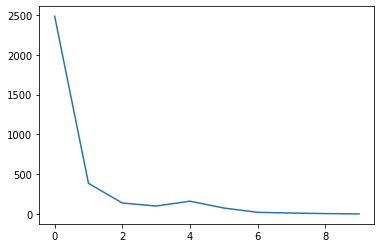

In [36]:
plt.plot(test_corpus.get_label_count_per_token_distro(conditional_rep = test_dir, return_format = 'list'))
plt.show()

## A few important examples

Calculating all the # of paragraphs

In [37]:
len(stat_df)

448

total number of tags in a specific column

In [40]:
total_corpus_dir = repository()
test_corpus.get_span_count(total_corpus_dir, columns = 'Curation')

16855

To test that this is true,this should be equal to the # of tags in the dataframe.
First drop the error columns 

In [42]:
stat_df = stat_df.drop(stat_df[stat_df.Curation == 'error'].index)

In [43]:
len(list(chain.from_iterable(stat_df['Curation'])))

16855

Annotated tokens to total tokens

In [44]:
#Total:
test_corpus.get_token_count_from_repository(total_corpus_dir)

263752

In [45]:
#annotated: (summing over all the tokens having a minimum one label)
sum(test_corpus.get_label_count_per_token_distro(total_corpus_dir, 'list')[1:])

61934